In [4]:
# channel
# 
# Band 1: SAR image, VV
# Band 2: SAR image, VH
# Band 3: Merit DEM
# Band 4: Copernicus DEM
# Band 5: ESA World Cover Map
# Band 6: Water occurrence probability

# 1,2 偏振0-1，0-？
# 3，4 高度 0-卫星高度
# 5 rgb 地图？
# 水没率

In [5]:
import PIL
from PIL import Image
import glob
from glob import glob
import cv2
import numpy as np
import tifffile
from tifffile import TiffFile
import matplotlib.pyplot as plt
import rasterio



# PATH

In [6]:
DATASET_ROOT='/home/syo/work/2024_IEEE_GRSS/dataset/'
TRACK1_ROOT='/home/syo/work/2024_IEEE_GRSS/dataset/Track1/'
TRACK2_ROOT='/home/syo/work/2024_IEEE_GRSS/dataset/Track2/'

In [7]:
images_list=sorted([i for i in glob(TRACK1_ROOT+'train/images/'+'*')])
label_list=sorted([i for i in glob(TRACK1_ROOT+'train/labels/'+'*')])

In [8]:
len(images_list)

1631

In [9]:
sample=images_list[0]
data=np.fromfile(sample,int)
#print(data.shape)
with TiffFile(sample) as tif:
    img=tif.asarray()
    print(img.shape)
    

(512, 512, 6)


In [10]:
sample

'/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/images/0.tif'

In [11]:
img.shape

(512, 512, 6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


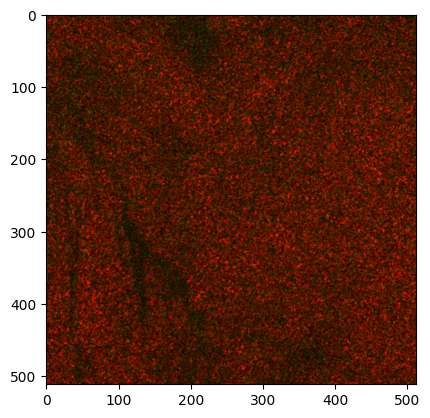

In [12]:

plt.imshow(img[:,:,0:3])

In [13]:
def display_sar(sar_data,num):
    sar_channels = [sar_data.read(i) for i in range(1, num+1)]
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(sar_channels[i], cmap='gray')
        ax.set_title(f'Channel {i + 1}')
        ax.axis('off')
    plt.show()

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(512, 512)


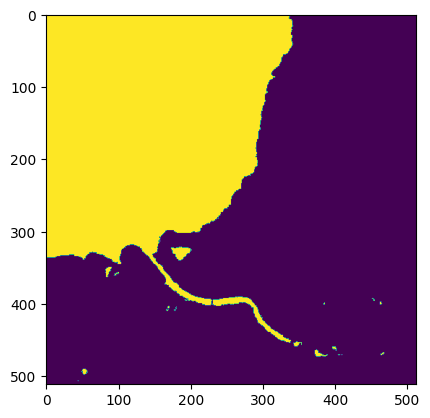

In [14]:
sample_map=np.array(Image.open(label_list[3]))
print(sample_map)
plt.imshow(sample_map)
print(sample_map.shape)

/home/syo/opt/mambaforge/envs/kaggle/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


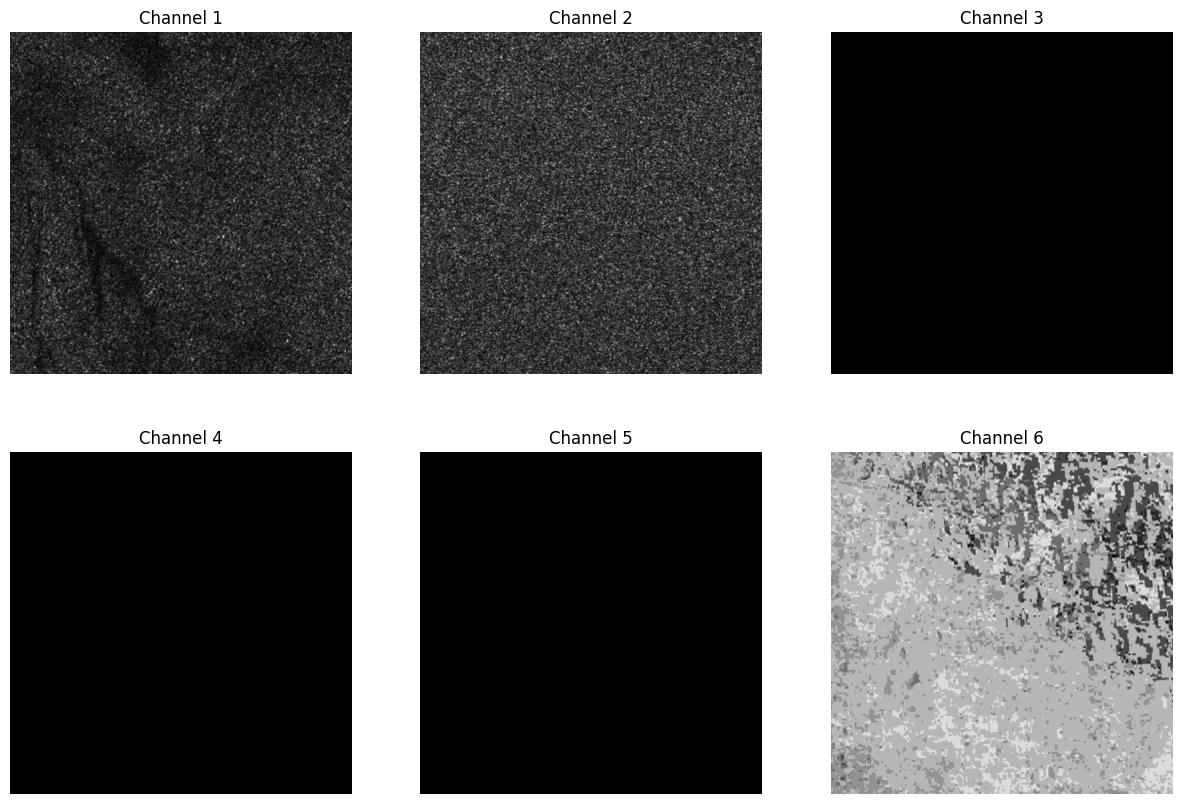

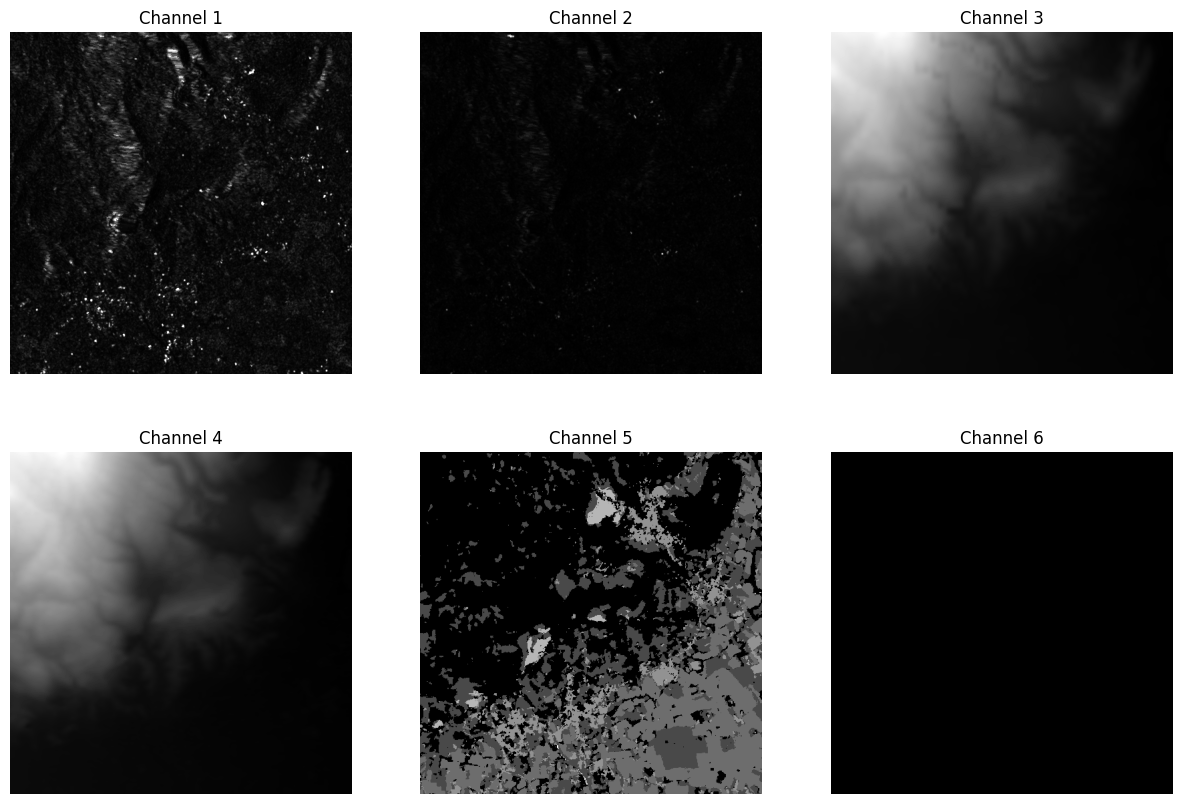

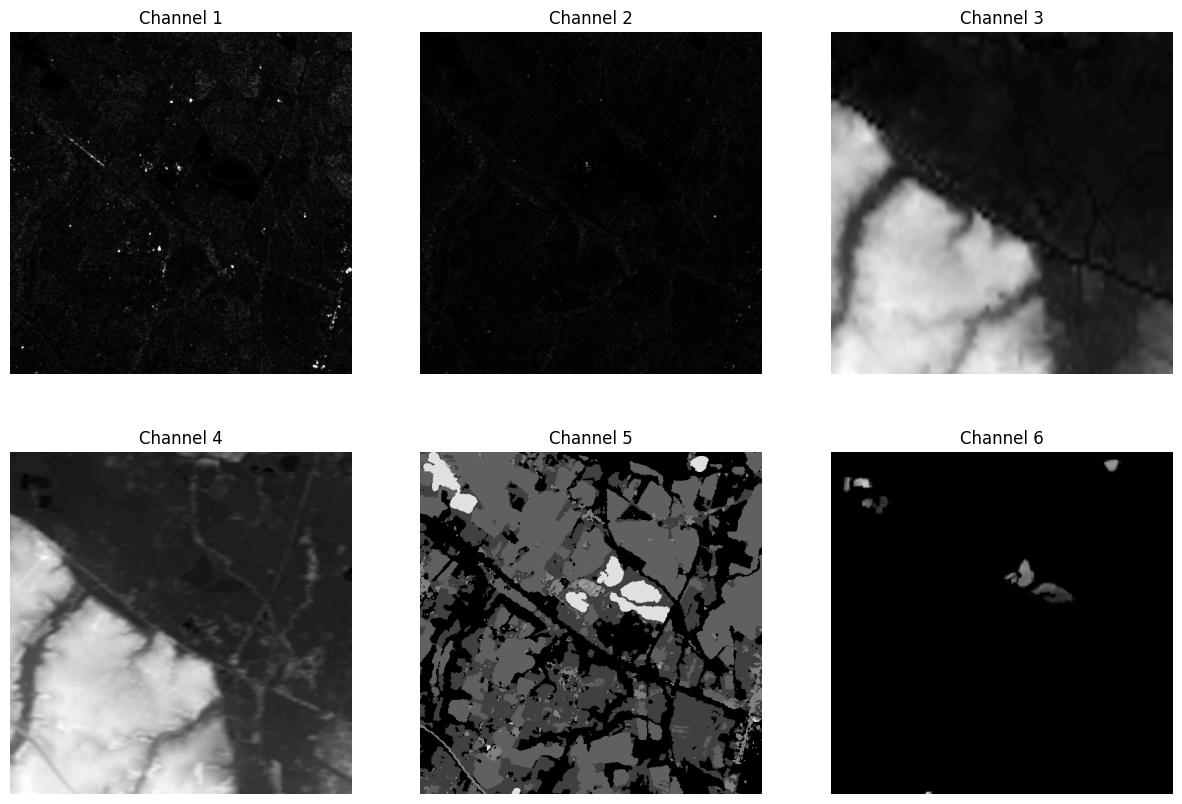

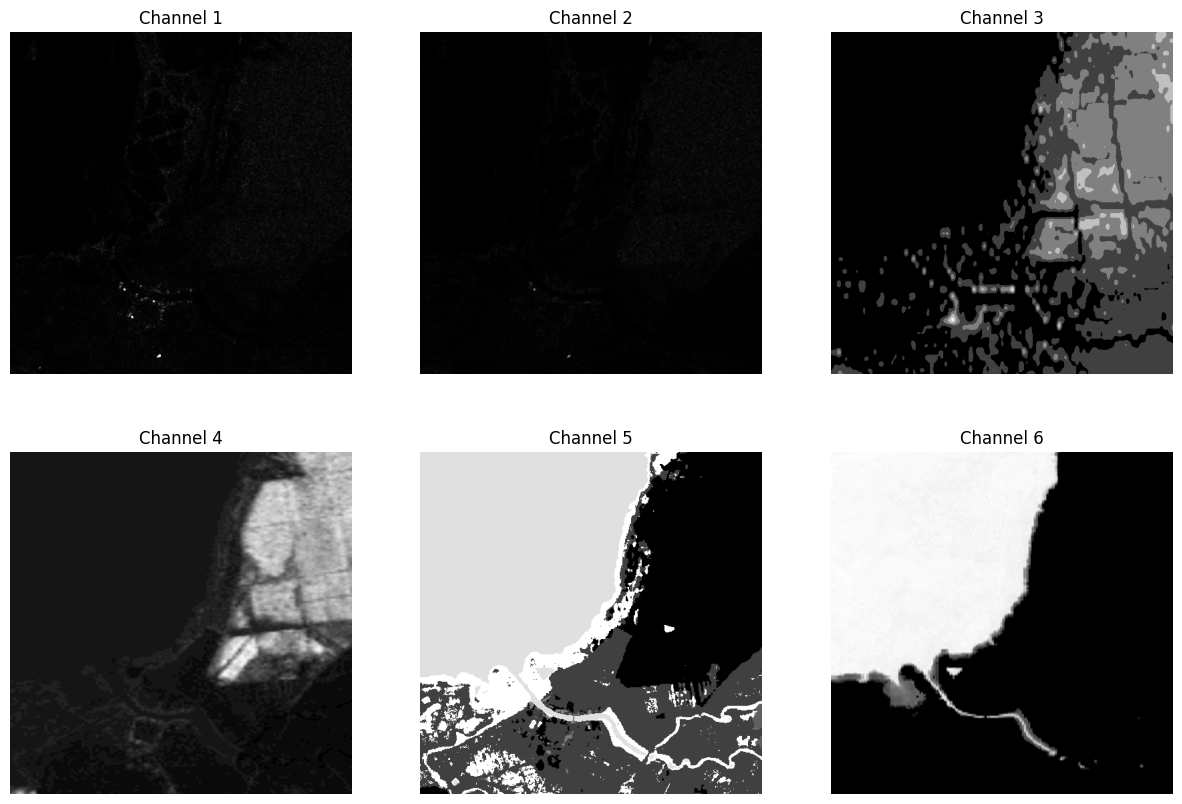

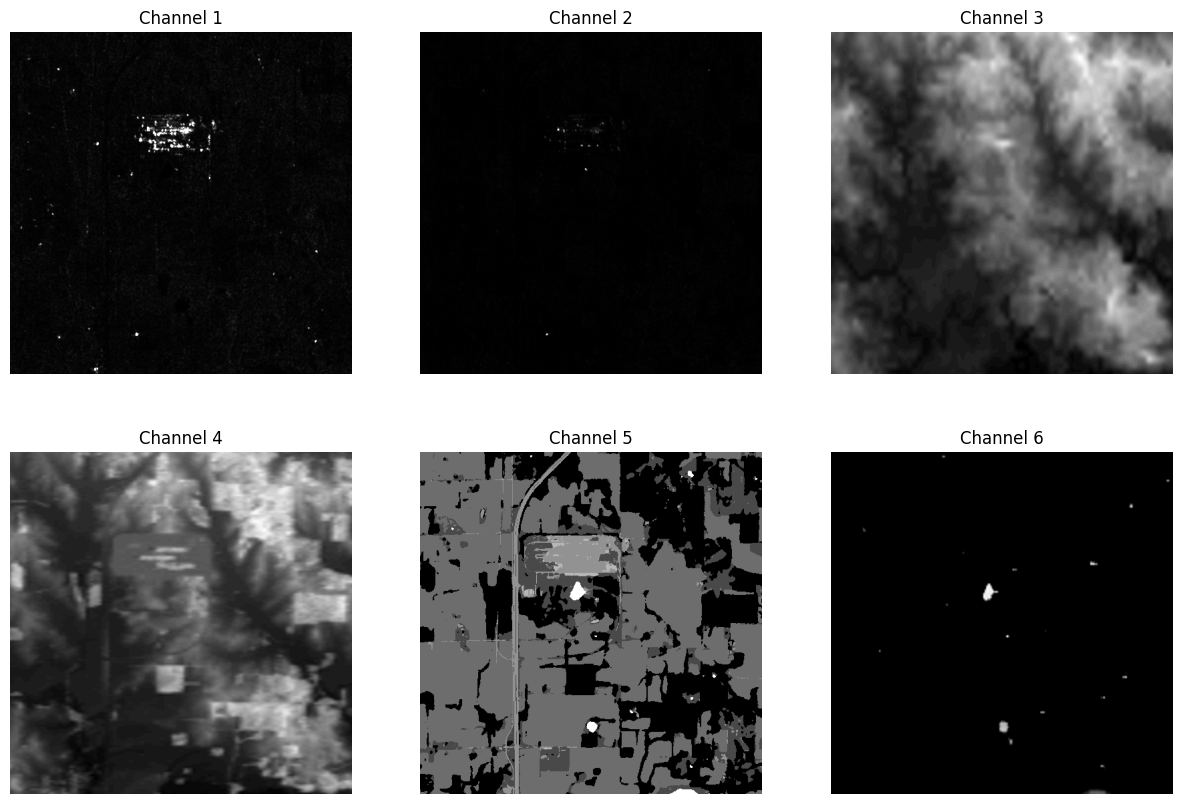

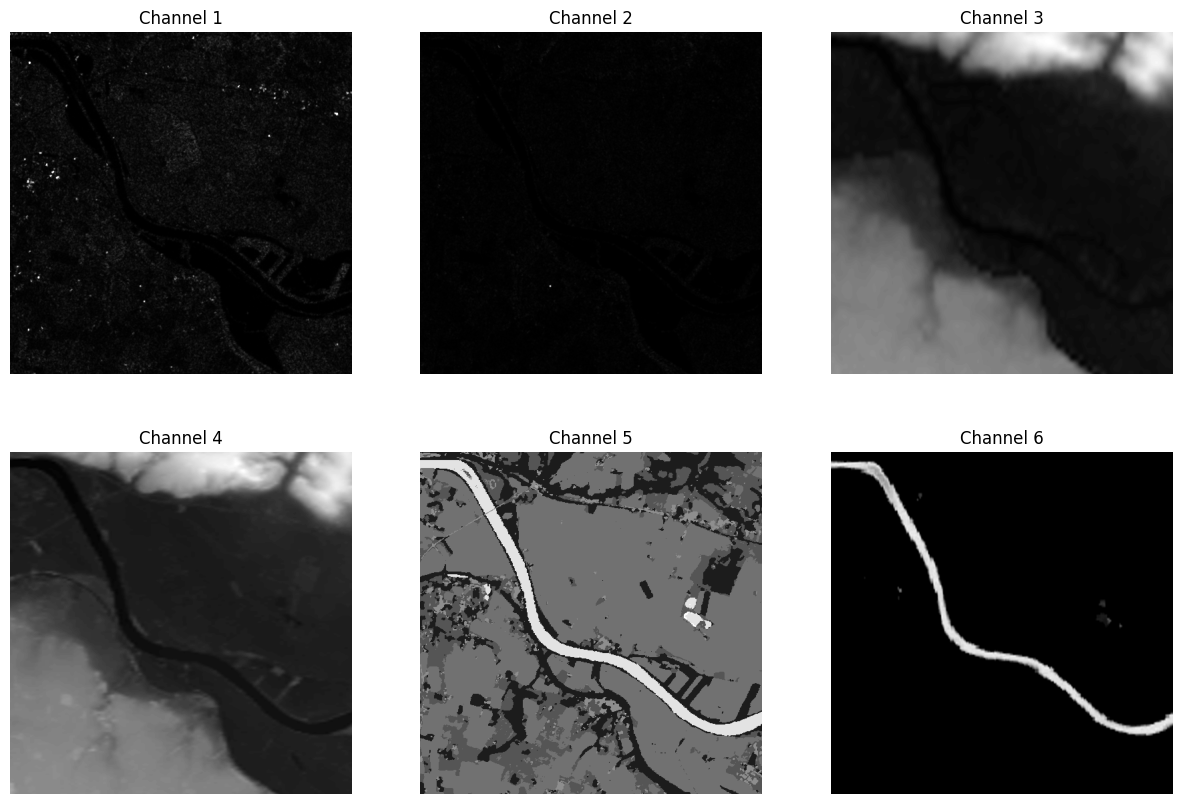

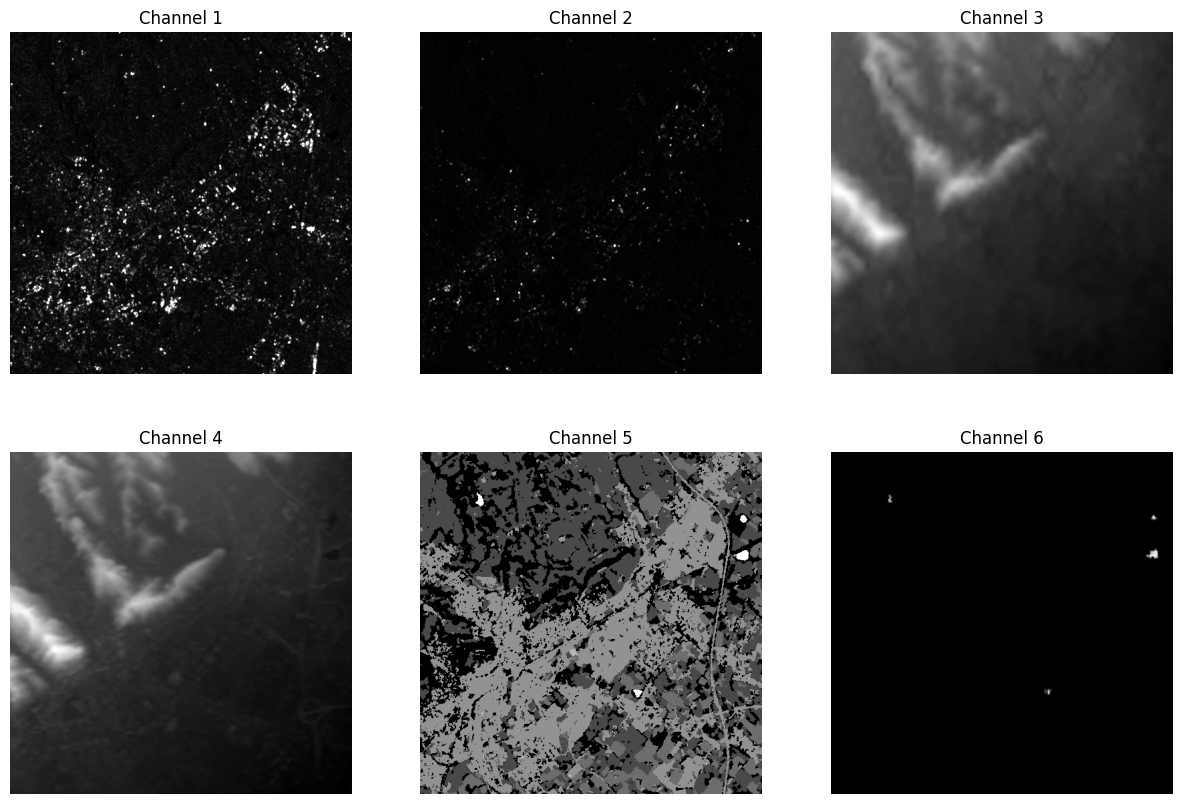

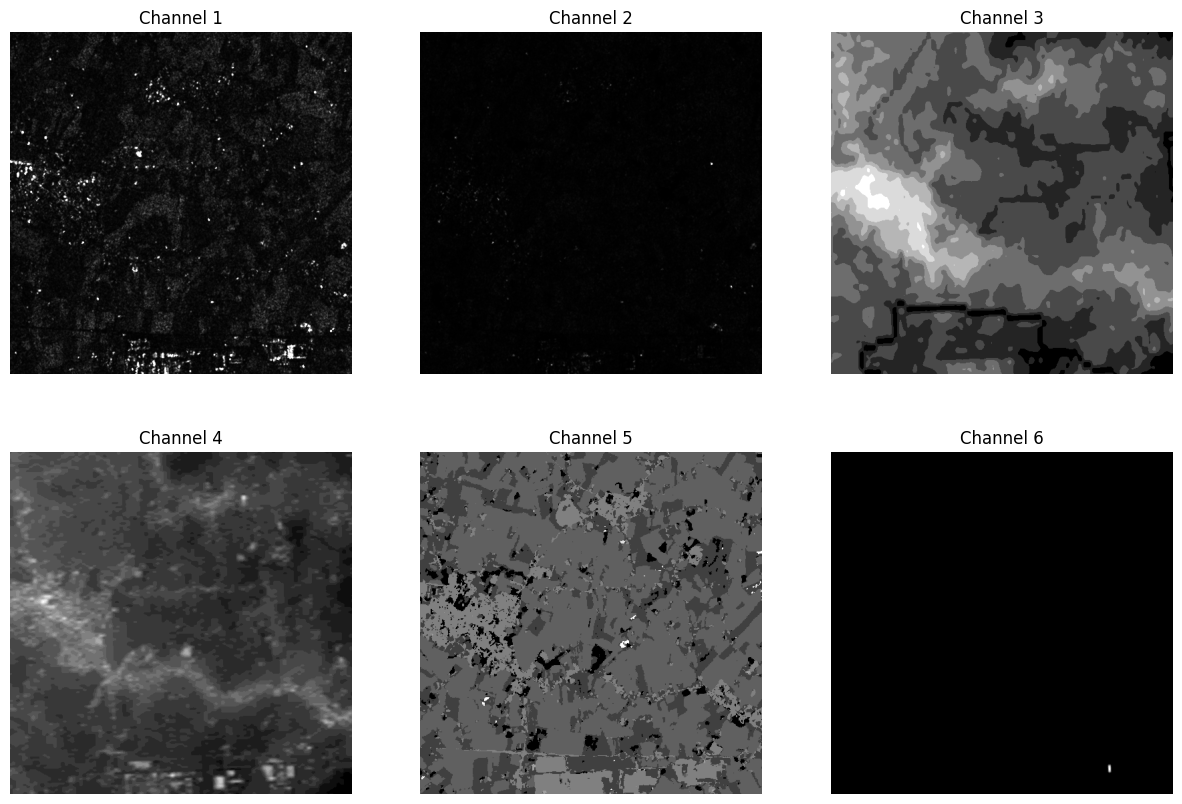

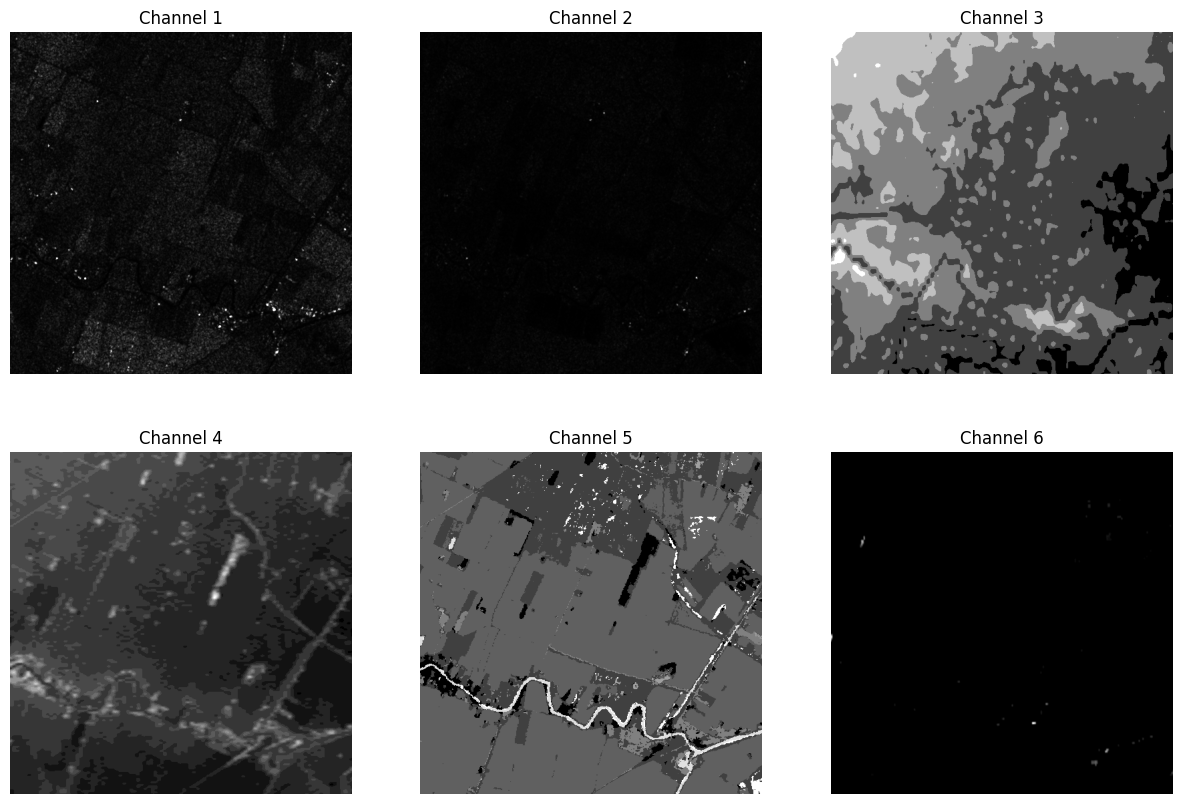

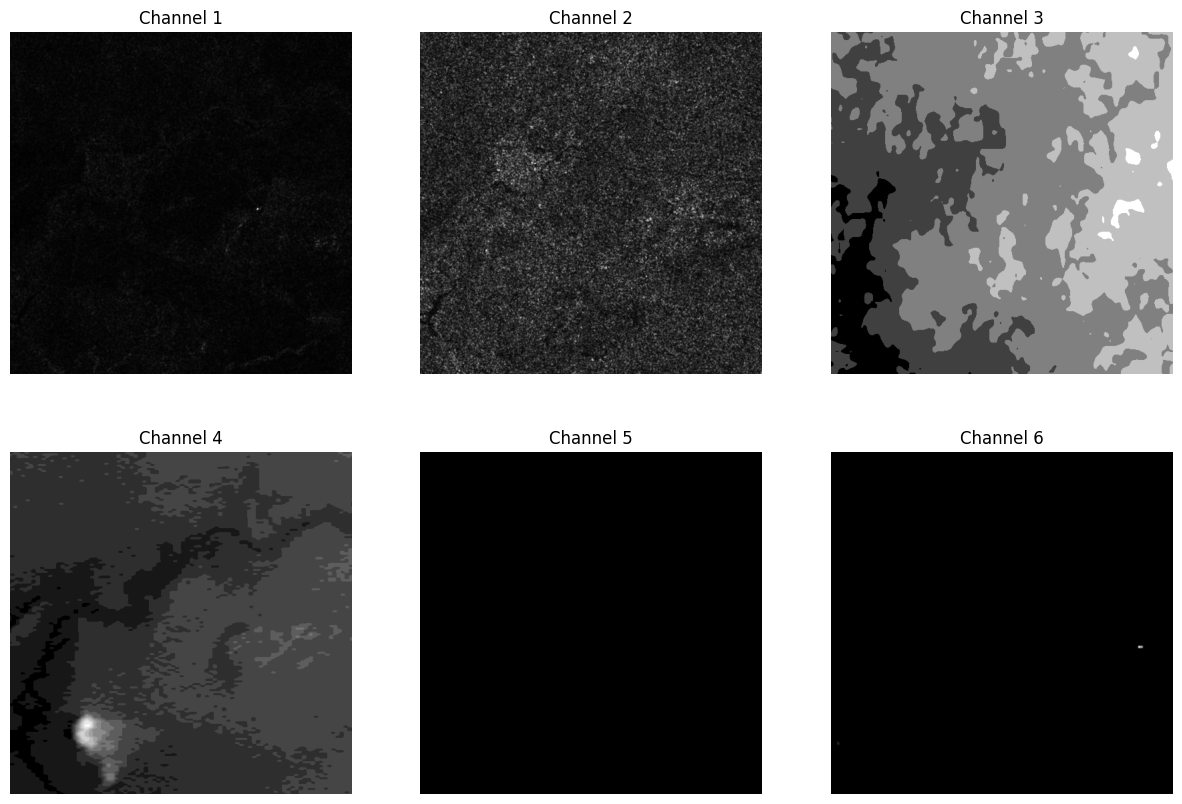

In [15]:
for i in images_list[:10]:
    sar_data = rasterio.open(i,dtype=rasterio.uint8)
    display_sar(sar_data=sar_data,num=6)

In [16]:
from dataset import SARDataset

In [17]:
train_dataset=SARDataset(
       image_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/images/",
       label_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/labels/",
       mode='train'
   )
val_dataset=SARDataset(
       image_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/images/",
       label_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/labels/",
       mode='val'
   )

In [18]:
n_max=[]
n_min=[]
for data in train_dataset:
    d=data['data']
    c1=d[0,:,:]
    n_max.append(c1.max())
    n_min.append(c1.min())

    #negative_indices = np.where(d < 0)
    #negative_count = len(negative_indices[0])
    #negative_values = d[negative_indices]
    #print(negative_count)
    #print(negative_values)
n_max=np.array(n_max)
n_min=np.array(n_min)
print(sorted(n_max))
print(sorted(n_min))


KeyboardInterrupt: 

# submit visualization test

In [ ]:
submit_path='./submit/'
submaks_list = sorted(list(glob(submit_path+'*')))

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

sample_map=np.array(Image.open(submaks_list[2]))
print(submaks_list[0])
print(sample_map)
plt.imshow(sample_map)
print(sample_map.shape)

# albumentations test

In [1]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from dataset import SARDataset
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import rasterio

/home/syo/opt/mambaforge/envs/kaggle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def display_sar(sar_data,num=6):
    fig, axs = plt.subplots(2, 3, figsize=(30, 20))
    for i, ax in enumerate(axs.flatten()):
        print(sar_data)
        ax.imshow(sar_data[i], cmap='gray')
        ax.set_title(f'Channel {i + 1}')
        ax.axis('off')
    #plt.show()

In [153]:
data_transforms = {
    "train": A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.GridDistortion(p=0.2),
            A.RandomResizedCrop(p=0.2,width=512,height=512),

            A.OneOf(
                [
                    A.GaussianBlur(),
                    A.GaussNoise(var_limit=(0,2e-8),mean=0,per_channel=True),
                ],
                p=0.2,
            ),
            #ToTensorV2(),
        ],
        p=1.0,
    ),
}

In [154]:
train_dataset=SARDataset(
    image_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/images/",
    label_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/labels/",
    mode='train',
    val_size=1e-10,
    data_transforms=data_transforms['train']
    )

tensor([[[3.3405e-02, 1.9789e-02, 6.8833e-03,  ..., 8.9609e-02,
          8.9661e-02, 5.9193e-02],
         [3.3054e-02, 3.4952e-02, 3.0446e-02,  ..., 8.3093e-02,
          4.7275e-02, 4.0001e-02],
         [3.9226e-02, 4.2683e-02, 7.5873e-02,  ..., 4.6408e-02,
          5.6759e-02, 7.0548e-02],
         ...,
         [7.8088e-02, 1.2244e-01, 1.4948e-01,  ..., 1.4135e-01,
          1.3655e-01, 4.7249e-01],
         [5.2623e-02, 8.0501e-02, 8.0584e-02,  ..., 1.7026e-01,
          7.5873e-02, 1.9234e-01],
         [2.5150e-02, 1.6157e-02, 1.4666e-02,  ..., 8.9208e-02,
          6.9879e-02, 9.1282e-02]],

        [[1.0396e-02, 1.2233e-02, 1.3648e-02,  ..., 3.3807e-02,
          3.3789e-02, 2.4342e-02],
         [2.1646e-03, 3.9429e-03, 4.3054e-03,  ..., 2.4713e-02,
          1.3692e-02, 1.0666e-02],
         [2.4790e-03, 3.4993e-03, 8.5638e-03,  ..., 2.0128e-02,
          1.0046e-02, 1.0930e-02],
         ...,
         [9.7331e-03, 2.5552e-03, 4.2602e-05,  ..., 5.2944e-03,
          8.562

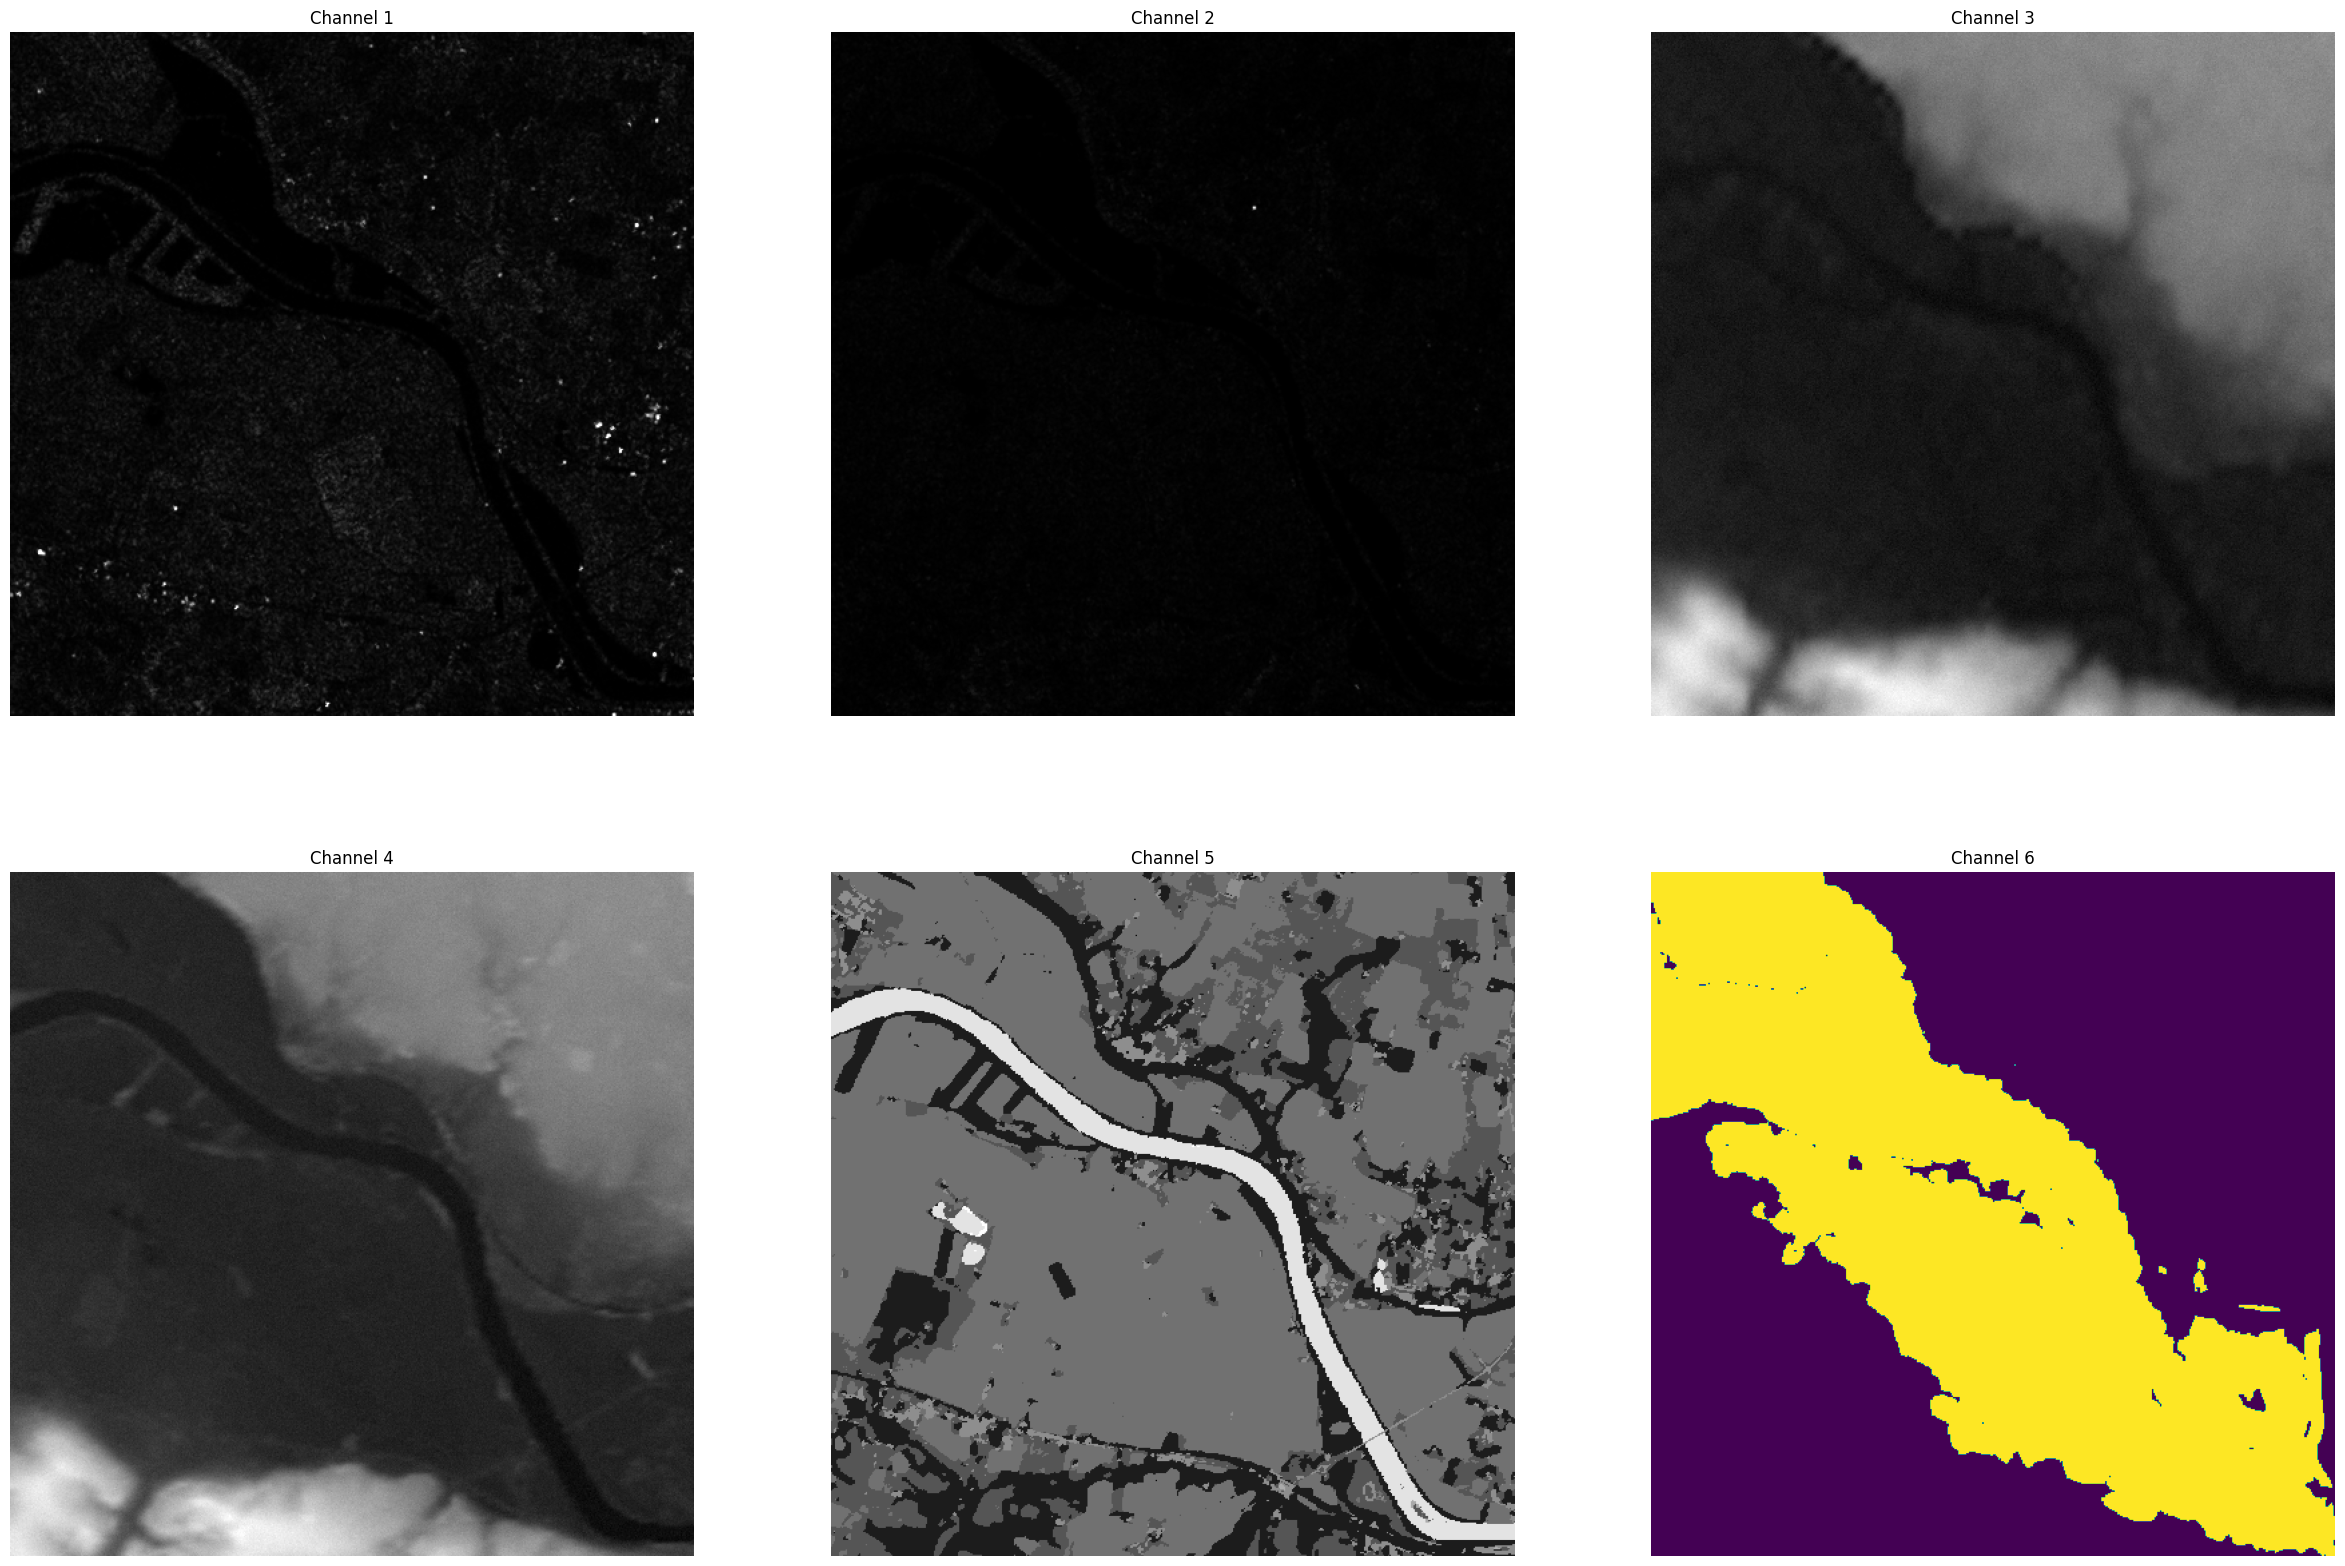

In [155]:
k=0
for i in train_dataset:
    k+=1
    if k==6:
        display_sar(i['data'])
        print(i['label'][2])
        plt.imshow(i['label'])
        break
    else:
        continue

In [13]:
train_dataset=SARDataset(
    image_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/images/",
    label_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/labels/",
    mode='train',
    val_size=1e-10,
    #data_transforms=data_transforms['train']
    )

In [ ]:
k=0
for i in train_dataset:
    k+=1
    if k==6:
        display_sar(i['data'])
        print(i['label'])
        plt.imshow(i['label'])
        break
    else:
        continue

# dataset

In [1]:
from dataset import SARDataset

/home/syo/opt/mambaforge/envs/kaggle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset=SARDataset(
       image_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/images/",
       label_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/labels/",
       mode='train'
   )

In [19]:
for j in range(6):
    nmin=1e10
    nmax=-1e10
    for i in train_dataset:
        a=i['data'][j]
        nmin=min(nmin,a.min())
        nmax=max(nmax,a.max())
    print(nmin,nmax)

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(0.6615)
tensor(0.4983) tensor(0.6601)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


In [ ]:
valid_dataset=SARDataset(
       image_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/images/",
       label_root="/home/syo/work/2024_IEEE_GRSS/dataset/Track1/train/labels/",
       mode='val')

for j in range(6):
    nmin=1e10
    nmax=-1e10
    for i in valid_dataset:
        a=i['data'][j]
        nmin=min(nmin,a.min())
        nmax=max(nmax,a.max())
    print(nmin,nmax)

In [ ]:
# normalization
# channel
# 1: 0-32765        x/32765
# 2:                x/32765
# 3: -9999:9999     (x+9999)/(9999*2)
# 4: 0-100          x/100
# 5: 0-255          x/255
